# TELCO CHURN - CUSTOMER SEGMENTATION VIA CLUSTERING


Customer segmentation via clustering:- understanding the profiles of non-Churn customers. 

Machinine learning steps covered in this notebook: 
* **Cleaning:** missing values, duplicate features. 
* **Clustering** via KPrototypes algorithm on mixed data types.  
_Customer segmentation without dimensionality reduction._

<b>Data:</b> Data on telco customers. It comprises the options within the plans and plan usage in terms of number and duration of calls, and revenue.

In [1]:
import pandas as pd
import numpy as np
from numpy import mean, std, NaN
from stop_words import get_stop_words
import scipy.stats as stats
import random 
#from random import seed
#seed(1)
from collections import Counter

import re
import nltk
#nltk.download('stopwords')
from nltk.corpus import stopwords, wordnet
from nltk.stem.porter import PorterStemmer#, SnowballStemmer
from nltk.tokenize import RegexpTokenizer, sent_tokenize, word_tokenize
#nltk.download('wordnet')
from nltk.stem.wordnet import WordNetLemmatizer 
from nltk import pos_tag 
#from gensim import models, corpora

import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot
import plotnine
from plotnine import *

import dash
import dash_core_components as dcc
import dash_html_components as html
import dash_table_experiments as dt
from plotly import graph_objects as go 
from plotly.graph_objs import * 
from dash.dependencies import Input, Output, State
import plotly.express as px 

from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline #as imbPipeline

from joblib import dump
from joblib import load
import pickle 

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score
from sklearn.decomposition import NMF, LatentDirichletAllocation
from datetime import datetime
from sklearn.preprocessing import LabelEncoder, FunctionTransformer, PowerTransformer, RobustScaler
from sklearn.feature_selection import SelectFromModel
#pip install libpysal
#pip install pygeos


# clustering
from kmodes.kprototypes import KPrototypes

from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.dummy import DummyClassifier 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier,BaggingClassifier , GradientBoostingClassifier,RandomForestClassifier,ExtraTreesClassifier,RandomForestRegressor

from imblearn.over_sampling import SMOTE 
from imblearn.combine import SMOTEENN
from sklearn.multiclass import OneVsRestClassifier

from sklearn.metrics import classification_report, confusion_matrix, auc, accuracy_score,log_loss,roc_auc_score,roc_curve, make_scorer,r2_score,jaccard_score
from imblearn.metrics import geometric_mean_score 

""" 
import rasterio as rio
import contextily as ctx
import shapely.geometry as geom
import folium
import osmnx as ox 
from shapely.ops import nearest_points
from shapely.geometry import LineString
import geopy
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
from folium.plugins import FastMarkerCluster
"""
#from libpysal.weights.distance import get_points_array
from scipy.spatial import cKDTree
import mapclassify
import geopandas as gpd

#factor analysis of mixed data
from light_famd import FAMD

pd.options.display.max_columns = 35
pd.options.display.float_format ='{:.2f}'.format 

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

# Load data

In [2]:
pd.options.display.max_columns = 35
pd.options.display.float_format ='{:.2f}'.format

telcofile = "TelcoChurn.xlsx"

t=pd.read_excel(telcofile)
#print(t.shape)
#t.isna().sum()
t.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 33 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   customerID            3333 non-null   object 
 1   gender                3333 non-null   object 
 2   SeniorCitizen         3333 non-null   int64  
 3   MaritalStatus         3333 non-null   object 
 4   Dependents            3333 non-null   object 
 5   tenure                3333 non-null   int64  
 6   PhoneService          3333 non-null   object 
 7   MultipleLines         3333 non-null   object 
 8   InternetService       3333 non-null   object 
 9   OnlineSecurity        3333 non-null   object 
 10  OnlineBackup          3333 non-null   object 
 11  DeviceProtection      3333 non-null   object 
 12  TechSupport           3333 non-null   object 
 13  StreamingTV           3333 non-null   object 
 14  StreamingMovies       3333 non-null   object 
 15  Contract             

In [3]:
t.head()

,customerID,gender,SeniorCitizen,MaritalStatus,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,InternationalPlan,VoiceMailPlan,NumbervMailMessages,TotalDayMinutes,TotalDayCalls,TotalEveMinutes,TotalEveCalls,TotalNightMinutes,TotalNightCalls,TotalIntlMinutes,TotalIntlCalls,CustomerServiceCalls,TotalCall,TotalRevenue,Churn
0,0002-ORFBO,Female,0,Yes,Yes,9,Yes,No,DSL,No,Yes,No,Yes,Yes,No,One year,Yes,Mailed check,No,No,0,168.80,137,241.40,107,204.80,106,15.50,4,0,354,593.3,No
1,0004-TLHLJ,Male,0,No,No,4,Yes,No,Fiber optic,No,No,Yes,No,No,No,Month-to-month,Yes,Electronic check,Yes,No,0,122.20,112,131.70,94,169.50,106,10.30,9,5,326,280.85,Yes
2,0013-MHZWF,Female,0,No,Yes,9,Yes,No,DSL,No,No,No,Yes,Yes,Yes,Month-to-month,Yes,Credit card (automatic),No,Yes,36,178.70,134,178.60,102,126.80,82,8.00,4,2,324,571.45,No
3,0013-SMEOE,Female,1,Yes,No,71,Yes,No,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,Yes,Bank transfer (automatic),No,No,0,190.20,68,262.20,64,130.00,92,8.80,4,0,228,7904.25,No
4,0015-UOCOJ,Female,1,No,No,7,Yes,No,DSL,Yes,No,No,No,No,No,Month-to-month,Yes,Electronic check,No,No,0,67.70,68,195.70,86,236.50,137,12.00,2,1,294,340.35,No


# Cleaning

In [4]:
# checking for duplicates in ID 

print(f"ID ={t.customerID.dtype}\n")
t.customerID.value_counts(dropna=False).head(10)

ID =object



2267-FPIMA    1
6645-MXQJT    1
5447-WZAFP    1
2805-AUFQN    1
9531-NSBMR    1
8731-WBBMB    1
9903-LYSAB    1
2122-SZZZD    1
4443-EMBNA    1
9845-QOMAD    1
Name: customerID, dtype: int64

In [5]:
t[t.duplicated(keep=False)].sort_values(by="customerID")
#t.drop_duplicates(inplace=True)


# id column below shows NO duplicates

,customerID,gender,SeniorCitizen,MaritalStatus,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,InternationalPlan,VoiceMailPlan,NumbervMailMessages,TotalDayMinutes,TotalDayCalls,TotalEveMinutes,TotalEveCalls,TotalNightMinutes,TotalNightCalls,TotalIntlMinutes,TotalIntlCalls,CustomerServiceCalls,TotalCall,TotalRevenue,Churn


In [6]:
t.SeniorCitizen = t.SeniorCitizen.astype('O')

t.SeniorCitizen.dtype

dtype('O')

#### Cleaning numerical variables

In [7]:
t['TotalRevenue'].dtype

dtype('O')

In [8]:
t.TotalRevenue.value_counts(dropna=False).head(10) 
# white / empty space with count of 5 items

19.75    8
19.55    7
20.05    7
19.65    7
19.9     6
20.2     6
45.3     5
         5
20.15    5
19.45    5
Name: TotalRevenue, dtype: int64

In [9]:
# converting TotalRevenue column with mixed data types to float 

t.TotalRevenue = pd.to_numeric(t.TotalRevenue, errors='coerce') # 
t.TotalRevenue.value_counts(dropna=False).head(10) 
#nan values below from previous empty/white space

19.75    8
19.55    7
19.65    7
20.05    7
20.20    6
19.90    6
NaN      5
45.30    5
20.45    5
19.45    5
Name: TotalRevenue, dtype: int64

In [10]:
t.info() 
# before = TotalRevenue    3333 non-null   object ; after cleaning=3328 non-null   float64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 33 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   customerID            3333 non-null   object 
 1   gender                3333 non-null   object 
 2   SeniorCitizen         3333 non-null   object 
 3   MaritalStatus         3333 non-null   object 
 4   Dependents            3333 non-null   object 
 5   tenure                3333 non-null   int64  
 6   PhoneService          3333 non-null   object 
 7   MultipleLines         3333 non-null   object 
 8   InternetService       3333 non-null   object 
 9   OnlineSecurity        3333 non-null   object 
 10  OnlineBackup          3333 non-null   object 
 11  DeviceProtection      3333 non-null   object 
 12  TechSupport           3333 non-null   object 
 13  StreamingTV           3333 non-null   object 
 14  StreamingMovies       3333 non-null   object 
 15  Contract             

In [11]:
# summary of different types of variables 
discrete_type = ['int16', 'int32', 'int64']
continuous_type =['float16', 'float32', 'float64']

# numerical: discrete vs continuous
discrete = [var for var in t.columns if t[var].dtype in discrete_type and t[var].nunique()<len(t)]
continuous = [var for var in t.columns if t[var].dtype in continuous_type and var not in discrete]
# combination 
string = [discrete, continuous]

# categorical
categorical = [var for var in t.columns if t[var].dtype=='O' and var not in string and t[var].nunique()!=len(t)]

string_all = [discrete, continuous, categorical]
unique_identifier = [var for var in t.columns if t[var].dtype=='O' and var not in string_all and t[var].nunique()==len(t)]

print(f'Total number of variables = {len(t.columns)}\n')
print('{} unique id '.format(len(unique_identifier)))
print('{} discrete variables'.format(len(discrete)))
print('{} continuous variables'.format(len(continuous)))
print('{} categorical variables'.format(len(categorical)))

#print('There are {} mixed variables'.format(len(mixed)))
print(f'\nUnique identifier = {unique_identifier}')
print(f'\nCategorical variables = {categorical}')
print(f'\nDiscrete variables = {discrete}')
print(f'\nContinuous variables = {continuous}')

t.head(2)

Total number of variables = 33

1 unique id 
8 discrete variables
5 continuous variables
19 categorical variables

Unique identifier = ['customerID']

Categorical variables = ['gender', 'SeniorCitizen', 'MaritalStatus', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'InternationalPlan', 'VoiceMailPlan', 'Churn']

Discrete variables = ['tenure', 'NumbervMailMessages', 'TotalDayCalls', 'TotalEveCalls', 'TotalNightCalls', 'TotalIntlCalls', 'CustomerServiceCalls', 'TotalCall']

Continuous variables = ['TotalDayMinutes', 'TotalEveMinutes', 'TotalNightMinutes', 'TotalIntlMinutes', 'TotalRevenue']


,customerID,gender,SeniorCitizen,MaritalStatus,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,InternationalPlan,VoiceMailPlan,NumbervMailMessages,TotalDayMinutes,TotalDayCalls,TotalEveMinutes,TotalEveCalls,TotalNightMinutes,TotalNightCalls,TotalIntlMinutes,TotalIntlCalls,CustomerServiceCalls,TotalCall,TotalRevenue,Churn
0,0002-ORFBO,Female,0,Yes,Yes,9,Yes,No,DSL,No,Yes,No,Yes,Yes,No,One year,Yes,Mailed check,No,No,0,168.80,137,241.40,107,204.80,106,15.50,4,0,354,593.30,No
1,0004-TLHLJ,Male,0,No,No,4,Yes,No,Fiber optic,No,No,Yes,No,No,No,Month-to-month,Yes,Electronic check,Yes,No,0,122.20,112,131.70,94,169.50,106,10.30,9,5,326,280.85,Yes


### Missing Values

In [12]:
t = t.dropna()

t.isna().sum()

customerID              0
gender                  0
SeniorCitizen           0
MaritalStatus           0
Dependents              0
tenure                  0
PhoneService            0
MultipleLines           0
InternetService         0
OnlineSecurity          0
OnlineBackup            0
DeviceProtection        0
TechSupport             0
StreamingTV             0
StreamingMovies         0
Contract                0
PaperlessBilling        0
PaymentMethod           0
InternationalPlan       0
VoiceMailPlan           0
NumbervMailMessages     0
TotalDayMinutes         0
TotalDayCalls           0
TotalEveMinutes         0
TotalEveCalls           0
TotalNightMinutes       0
TotalNightCalls         0
TotalIntlMinutes        0
TotalIntlCalls          0
CustomerServiceCalls    0
TotalCall               0
TotalRevenue            0
Churn                   0
dtype: int64

In [13]:
# Inspect data of type object 
t.select_dtypes('object').nunique()

customerID           3328
gender                  2
SeniorCitizen           2
MaritalStatus           2
Dependents              2
PhoneService            1
MultipleLines           2
InternetService         3
OnlineSecurity          3
OnlineBackup            3
DeviceProtection        3
TechSupport             3
StreamingTV             3
StreamingMovies         3
Contract                3
PaperlessBilling        2
PaymentMethod           4
InternationalPlan       2
VoiceMailPlan           2
Churn                   2
dtype: int64

In [14]:
# The distribution of call per gender 
t_r = pd.DataFrame(t['gender'].value_counts()).reset_index()
t_r['percentage'] = t_r['gender'] / t['gender'].value_counts().sum()
t_r.rename(columns = {'index':'gender', 'gender':'total'}, inplace = True)
t_r = t_r.sort_values('total', ascending = True).reset_index(drop = True)

# The dataframe
t_r = t.groupby('gender').agg({
    'gender': 'count',
    'tenure':'sum',
    'CustomerServiceCalls': 'sum',
    'TotalDayMinutes':'sum',
    'TotalIntlCalls':'sum',
    'TotalCall': 'sum',
    'TotalRevenue': 'mean'
    }
).rename(columns = {'gender': 'Total'}).reset_index().sort_values('Total', ascending = True)

t_r

,gender,Total,tenure,CustomerServiceCalls,TotalDayMinutes,TotalIntlCalls,TotalCall,TotalRevenue
0,Female,1619,45271,2552,291386.90,7272,496890,1642.93
1,Male,1709,48058,2647,306862.90,7636,523869,1702.03


In [15]:
# Order the index of cross tabulation
o_r = t_r['gender'].to_list()
#order_region.append('TotalRevenue')
# distribution of item type
df_item = pd.crosstab(t['gender'], t['InternetService'], margins = True).reindex(o_r, axis = 0).reset_index()
# Remove index name
df_item.columns.name = None
df_item

,gender,DSL,Fiber optic,No,All
0,Female,499,545,575,1619
1,Male,536,573,600,1709


# Pre-Processing & clustering

In [16]:
# Removing values not needed for clustering / customer segmentation 
df0 = t.copy()

#limiting to non-churn customers 
df0 = df0.loc[df0.Churn == 'No']

df0.drop(['customerID','Churn'], axis = 1, inplace = True)

# Show the data after pre-processing
print('Shape: {} rows and {} columns'.format(len(df0), len(df0.columns)))
df0.head(2)

Shape: 2845 rows and 31 columns


,gender,SeniorCitizen,MaritalStatus,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,InternationalPlan,VoiceMailPlan,NumbervMailMessages,TotalDayMinutes,TotalDayCalls,TotalEveMinutes,TotalEveCalls,TotalNightMinutes,TotalNightCalls,TotalIntlMinutes,TotalIntlCalls,CustomerServiceCalls,TotalCall,TotalRevenue
0,Female,0,Yes,Yes,9,Yes,No,DSL,No,Yes,No,Yes,Yes,No,One year,Yes,Mailed check,No,No,0,168.80,137,241.40,107,204.80,106,15.50,4,0,354,593.30
2,Female,0,No,Yes,9,Yes,No,DSL,No,No,No,Yes,Yes,Yes,Month-to-month,Yes,Credit card (automatic),No,Yes,36,178.70,134,178.60,102,126.80,82,8.00,4,2,324,571.45


In [17]:
# cluster dataframe 

df = df0.iloc[:,:20]
#df.columns

# Get the position of categorical columns
catColumnsPos = [df.columns.get_loc(col) for col in list(df.select_dtypes('object').columns)]
print('Categorical columns           : {}'.format(list(df.select_dtypes('object').columns)))
print('Categorical columns position  : {}'.format(catColumnsPos))

Categorical columns           : ['gender', 'SeniorCitizen', 'MaritalStatus', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'InternationalPlan', 'VoiceMailPlan']
Categorical columns position  : [0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]


In [18]:
# Convert cluster dataframe to matrix
dfMatrix = df.to_numpy()
dfMatrix

array([['Female', 0, 'Yes', ..., 'No', 'No', 0],
       ['Female', 0, 'No', ..., 'No', 'Yes', 36],
       ['Female', 1, 'Yes', ..., 'No', 'No', 0],
       ...,
       ['Female', 0, 'No', ..., 'No', 'No', 0],
       ['Male', 0, 'No', ..., 'No', 'Yes', 14],
       ['Male', 0, 'Yes', ..., 'No', 'No', 0]], dtype=object)

### Clustering

Cluster initiation: 1
Cluster initiation: 2
Cluster initiation: 3
Cluster initiation: 4
Cluster initiation: 5


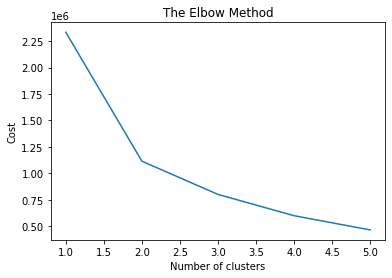

In [19]:
# Determining the number of clusters via Elbow method 
cost_list = []


for cluster in range(1,6):
    kprototype = KPrototypes(n_jobs = -1, n_clusters = cluster, init = 'Huang', random_state = 0)
    kprototype.fit_predict(dfMatrix, categorical = catColumnsPos)
    cost_list.append(kprototype.cost_)
    print('Cluster initiation: {}'.format(cluster))
    
#plot the graph of wcss values
plt.plot(range(1,6), cost_list)
plt.title("The Elbow Method")
plt.xlabel('Number of clusters')
plt.ylabel('Cost')
plt.show()

In [20]:
# Fit the cluster
kprototype = KPrototypes(n_jobs = -1, n_clusters = 2, init = 'Huang', random_state = 0)
predictions = kprototype.fit_predict(dfMatrix, categorical = catColumnsPos)
predictions

array([1, 1, 0, ..., 1, 1, 0], dtype=uint16)

In [21]:
# Cluster centorid
print('\nCluster centroid: ', kprototype.cluster_centroids_)

# Check the iteration of the clusters created
print('\nCluster iteration: ', kprototype.n_iter_)

# Check the cost of the clusters created
print('\nCost of clusters: ', kprototype.cost_)


Cluster centroid:  [['55.64065180102916' '9.194682675814752' 'Male' '0' 'Yes' 'No' 'Yes'
  'No' 'No' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Two year' 'Yes'
  'Credit card (automatic)' 'No' 'No']
 ['13.799285288862418' '8.185824895771292' 'Male' '0' 'No' 'No' 'Yes'
  'No' 'No' 'No internet service' 'No internet service'
  'No internet service' 'No internet service' 'No internet service'
  'No internet service' 'Month-to-month' 'No' 'Mailed check' 'No' 'No']]

Cluster iteration:  5

Cost of clusters:  1114287.898080715


In [22]:
# Add the cluster to the dataframe
df['cluster_label'] = kprototype.labels_
df['segment'] = df['cluster_label'].map({0:'first', 1:'second'})
# Order the cluster
df['segment'] = df['segment'].astype('category')
df['segment'] = df['segment'].cat.reorder_categories(['first','second'])
df.head(3)

,gender,SeniorCitizen,MaritalStatus,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,InternationalPlan,VoiceMailPlan,NumbervMailMessages,cluster_label,segment
0,Female,0,Yes,Yes,9,Yes,No,DSL,No,Yes,No,Yes,Yes,No,One year,Yes,Mailed check,No,No,0,1,second
2,Female,0,No,Yes,9,Yes,No,DSL,No,No,No,Yes,Yes,Yes,Month-to-month,Yes,Credit card (automatic),No,Yes,36,1,second
3,Female,1,Yes,No,71,Yes,No,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,Yes,Bank transfer (automatic),No,No,0,0,first


In [23]:
""" 
df = df0.iloc[:,:20]
"""
df0_exp = df0.iloc[:, 20:]
merged_df = pd.concat([df0_exp, df], axis=1)


print(merged_df.shape)
merged_df.head(2)

(2845, 33)


,TotalDayMinutes,TotalDayCalls,TotalEveMinutes,TotalEveCalls,TotalNightMinutes,TotalNightCalls,TotalIntlMinutes,TotalIntlCalls,CustomerServiceCalls,TotalCall,TotalRevenue,gender,SeniorCitizen,MaritalStatus,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,InternationalPlan,VoiceMailPlan,NumbervMailMessages,cluster_label,segment
0,168.80,137,241.40,107,204.80,106,15.50,4,0,354,593.30,Female,0,Yes,Yes,9,Yes,No,DSL,No,Yes,No,Yes,Yes,No,One year,Yes,Mailed check,No,No,0,1,second
2,178.70,134,178.60,102,126.80,82,8.00,4,2,324,571.45,Female,0,No,Yes,9,Yes,No,DSL,No,No,No,Yes,Yes,Yes,Month-to-month,Yes,Credit card (automatic),No,Yes,36,1,second


# Interpretation of customer segmentation

In [24]:
merged_df.groupby('segment')['PaymentMethod'].value_counts()

segment  PaymentMethod            
first    Credit card (automatic)      385
         Bank transfer (automatic)    354
         Mailed check                 228
         Electronic check             199
second   Mailed check                 702
         Electronic check             431
         Bank transfer (automatic)    275
         Credit card (automatic)      271
Name: PaymentMethod, dtype: int64

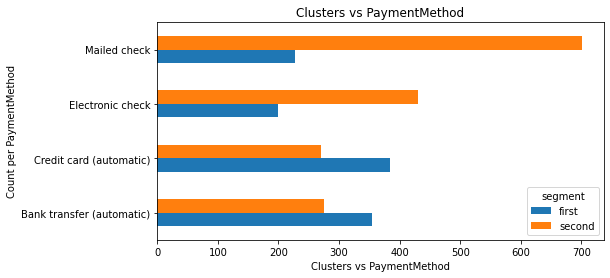

In [25]:
ax = merged_df.groupby(['segment','PaymentMethod'])['segment'].count().unstack(0).\
                plot.barh(title="Clusters vs PaymentMethod", figsize=(8,4))
_ = ax.set_xlabel('Clusters vs PaymentMethod')
_ = ax.set_ylabel('Count per PaymentMethod')

In [26]:
merged_df.rename(columns = {'cluster_label':'Total'}, inplace = True)
merged_df.groupby('segment').agg(
    {
        'Total':'count',
        'gender': lambda x: x.value_counts().index[0],
        'SeniorCitizen': lambda x: x.value_counts().index[0],
        'MaritalStatus': lambda x: x.value_counts().index[0],
        'Dependents': lambda x: x.value_counts().index[0],
        'PhoneService': lambda x: x.value_counts().index[0],
        'MultipleLines': lambda x: x.value_counts().index[0],
        'InternetService': lambda x: x.value_counts().index[0],
        'OnlineSecurity': lambda x: x.value_counts().index[0],
        'OnlineBackup': lambda x: x.value_counts().index[0],
        'DeviceProtection': lambda x: x.value_counts().index[0],
        'TechSupport': lambda x: x.value_counts().index[0],
        'StreamingTV': lambda x: x.value_counts().index[0],
        'StreamingMovies': lambda x: x.value_counts().index[0],
        'Contract': lambda x: x.value_counts().index[0],
        'PaperlessBilling': lambda x: x.value_counts().index[0],
        'PaymentMethod': lambda x: x.value_counts().index[0],
        'InternationalPlan': lambda x: x.value_counts().index[0],
        'VoiceMailPlan': lambda x: x.value_counts().index[0],
        'TotalDayMinutes': 'mean',
        'TotalDayCalls': 'mean',
        'TotalEveMinutes': 'mean',
        'TotalEveCalls': 'mean',
        'TotalNightMinutes': 'mean',
         'TotalNightCalls': 'mean',
        'TotalIntlMinutes': 'mean',
        'TotalIntlCalls': 'mean',
        'TotalEveCalls': 'mean',
        'TotalNightMinutes': 'mean',
        'TotalRevenue':'mean'
    }
).reset_index()

,segment,Total,gender,SeniorCitizen,MaritalStatus,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,InternationalPlan,VoiceMailPlan,TotalDayMinutes,TotalDayCalls,TotalEveMinutes,TotalEveCalls,TotalNightMinutes,TotalNightCalls,TotalIntlMinutes,TotalIntlCalls,TotalRevenue
0,first,1166,Male,0,Yes,No,Yes,No,No,Yes,Yes,Yes,Yes,Yes,Yes,Two year,Yes,Credit card (automatic),No,No,174.20,100.47,196.71,100.43,199.16,100.33,10.18,4.64,3411.92
1,second,1679,Male,0,No,No,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,No,No,175.81,100.15,200.68,99.79,200.84,99.89,10.14,4.46,707.09


In [27]:
#customer_plan_options = list(merged_df.columns[11:-3])
customer_plan_options = ['gender', 'SeniorCitizen', 'MaritalStatus', 'Dependents', #'tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'InternationalPlan', 'VoiceMailPlan']

#customer_output = list(merged_df.columns[:11])
customer_output = ['tenure','TotalDayMinutes', 'TotalDayCalls', 'TotalEveMinutes', 'TotalEveCalls',
       'TotalNightMinutes', 'TotalNightCalls', 'TotalIntlMinutes',
       'TotalIntlCalls', 'CustomerServiceCalls', 'TotalCall', 'TotalRevenue']

cluster0 = merged_df[merged_df['segment'] == 'first'].reset_index(drop=True)
cluster1 = merged_df[merged_df['segment'] == 'second'].reset_index(drop=True)

lst_clus0 = []
for col in cluster0[customer_plan_options].columns.tolist():
    c0_options_df = pd.DataFrame( cluster0[col].value_counts(normalize=True) ).unstack()
    lst_clus0.append(c0_options_df)

c0cpo = pd.concat(lst_clus0)
c0cpo1 = pd.DataFrame(c0cpo)
c0cpo1.columns = ['segment_0']


lst_clus1 = []
for col in cluster1[customer_plan_options].columns.tolist():
    c1_options_df = pd.DataFrame( cluster1[col].value_counts(normalize=True) ).unstack()
    lst_clus1.append(c1_options_df)

c1cpo = pd.concat(lst_clus1)
c1cpo1 = pd.DataFrame(c1cpo)
c1cpo1.columns = ['segment_1']

segments_df0 = pd.concat([c0cpo1,c1cpo1], axis=1)
segments_df0 = segments_df0.fillna(0)*100

segments_df1 = segments_df0.reset_index() 
segments_df0[:70]

segment_0  segment_1
Contract          Month-to-month                 14.75      69.62
                  One year                       32.16      21.14
                  Two year                       53.09       9.23
Dependents        No                             56.69      70.99
                  Yes                            43.31      29.01
DeviceProtection  No                             25.47      41.04
                  No internet service            34.91      42.64
                  Yes                            39.62      16.32
InternationalPlan No                             93.91      93.21
                  Yes                             6.09       6.79
InternetService   DSL                            33.19      31.15
                  Fiber optic                    31.90      26.21
                  No                             34.91      42.64
MaritalStatus     No                             34.99      64.62
                  Yes                            65.01      35.38
MultipleLines     No                             80.62      95.06
                  Yes                            19.38       4.94
OnlineBackup      No                             25.04      39.61
                  No internet service            34.91      42.64
                  Yes                            40.05      17.75
OnlineSecurity    No                             27.10      40.14
                  No internet service            34.91      42.64
                  Yes                            37.99      17.21
PaperlessBilling  No                             48.03      54.20
                  Yes                            51.97      45.80
PaymentMethod     Bank transfer (automatic)      30.36      16.38
                  Credit card (automatic)        33.02      16.14
                  Electronic check               17.07      25.67
                  Mailed check                   19.55      41.81
PhoneService      Yes                           100.00     100.00
SeniorCitizen     0                              89.71      90.89
                  1                              10.29       9.11
StreamingMovies   No                             27.19      38.48
                  No internet service            34.91      42.64
                  Yes                            37.91      18.88
StreamingTV       No                             27.02      40.02
                  No internet service            34.91      42.64
                  Yes                            38.08      17.33
TechSupport       No                             28.04      39.25
                  No internet service            34.91      42.64
                  Yes                            37.05      18.11
VoiceMailPlan     No                             68.78      71.65
                  Yes                            31.22      28.35
gender            Female                         49.23      47.41
                  Male                           50.77      52.59

In [28]:
# average output 

customer_output_df = merged_df.copy()
merged_df.segment = merged_df.segment.astype('object')

customer_output_df = merged_df.groupby('segment')[customer_output].mean()
customer_output_df

,tenure,TotalDayMinutes,TotalDayCalls,TotalEveMinutes,TotalEveCalls,TotalNightMinutes,TotalNightCalls,TotalIntlMinutes,TotalIntlCalls,CustomerServiceCalls,TotalCall,TotalRevenue
segment,,,,,,,,,,,,
first,55.64,174.20,100.47,196.71,100.43,199.16,100.33,10.18,4.64,1.43,307.30,3411.92
second,13.80,175.81,100.15,200.68,99.79,200.84,99.89,10.14,4.46,1.46,305.75,707.09


In [29]:
a = customer_output_df.copy() 
a2 = a.reset_index(drop=False).T.reset_index()
a2.columns = ['customer_output','first_segment','second_segment']
a2.iloc[1:,:]

,customer_output,first_segment,second_segment
1,tenure,55.64,13.8
2,TotalDayMinutes,174.2,175.81
3,TotalDayCalls,100.47,100.15
4,TotalEveMinutes,196.71,200.68
5,TotalEveCalls,100.43,99.79
6,TotalNightMinutes,199.16,200.84
7,TotalNightCalls,100.33,99.89
8,TotalIntlMinutes,10.18,10.14
9,TotalIntlCalls,4.64,4.46
10,CustomerServiceCalls,1.43,1.46
